In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from adafnn import MyAdaFNN
from train import train_pipeline, test_pipeline

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Introduction

&emsp; In the field of functional data analysis, basis expansion methods have been traditionally used to model intrinsically infinite-dimensional functions in finite-dimensional space. Among basis expansion methods, two of the most popular are B-spline and Functional Principal Component Analysis (FPCA). B-spline uses a set of $M$ pre-determined basis functions $\{B_1(t), \cdots, B_M(t) \}$ to model a given functional data $X_n$ as $X_n(t) \approx \sum_{m=1}^M c_{nm} B_m(t)$, where $c_{nm}$ is the coefficient for the $n\text{-th}$ data and $m\text{-th}$ basis. In FPCA, a set of $M$ orthonormal eigenvectors $\{v_1(t), \cdots, v_M(t) \}$ is used as basis functions, so that the functional data $X_n$ is modeled as $X_n(t) \approx \sum_{m=1}^M \xi_{nm} v_m(t)$ where $\xi_{nm} = \langle X_n, v_m \rangle$ is the $m \text{-th}$ PC score for $X_n$ (assuming that $X_n$ is centered).

&emsp; Current basis expansion methods have proven to work quite well for functional data analysis, but they do pose some drawbacks. First and foremost, selection of basis functions must be preceded before fitting the data (for B-spline). This means that we cannot choose basis functions that are optimal for each dataset. Also, current methods don't take advange of information in the output and only try to capture the information in input (for FPCA). To address these problems, Yao et al.[1] introduced a method of adaptively learning basis functions using neural networks.

# AdaFNN

&emsp; AdaFNN is a model introduced by Yao et al.[1] in 2021, where we use micro neural networks to adaptively learn basis functions using information from the target via backpropagation. The key idea is that adaptive basis layers can learn to focus on information relevant to the
target, thus enabling the construction of optimal basis functions

## Architecture

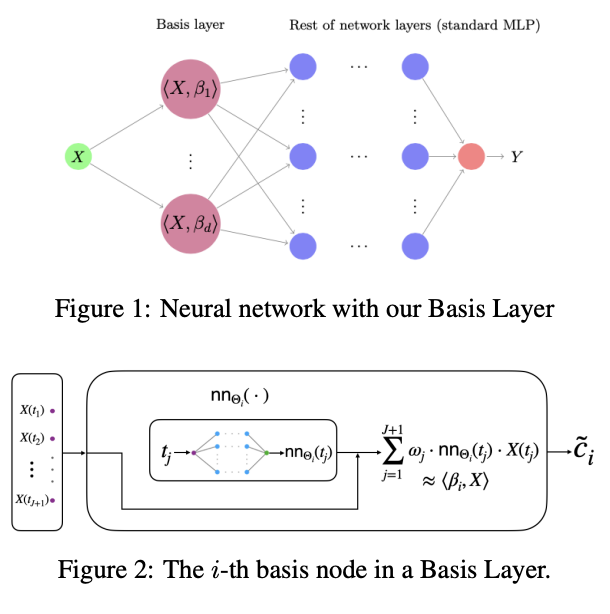

&emsp; The above image from [1] is an illustration of the network. The Basis Layer consists of $d$ Basis Nodes, where each Basis Node is a micro neural networks that takes time points as input. For each Basis Node, the time points are pases through consecutive feed-forward netwoks, and outputs the basis value correspoding to each time point. Thus, each Basis Node produces one basis function. After constructing $d$ basis functions, we compute the inner product between the input and each basis function via numerical integration, which results in a vector of size $d$. This vector is passed on to the subsequent network to be used for the downstream task. This network can be trained end-to-end and all layers are differentiable, which means information regarding the target can be reflected in constructing basis finctions via backpropagation. Additionally, some regularizations are applied to the loss function to encourage basis orthogonality and basis sparsity, and we refer interested readers to [1] for more detail.

# Network for recovering underlying curve from contaminated discrete observations

&emsp; We utilize the basic idea of adapative basis layers used in AdaFNN, but make some change in architecture. Before going in, it will be critical to point out that our task is different from that of the original paper. The original paper aimed to predict a scalar output from a functional input (scalar-on-function scheme), while we aim to reconstruct the underlying function from discrete observations contaminated by noise (function-on-function scheme).

## Architecture Change

&emsp; We still use the same network

## Parceval's Theorem

Parceval's Theorem states as the following: Letting $\{e_i\}$ be an orthonormal basis of a real separable Hilbert space $\mathcal{H}$, then for any $x \in \mathcal{H}$ we have
    $$
    x = \sum_{i=1}^\infty \langle x, e_i \rangle e_i
    $$
By constructing the output of the network to have the form $\sum_i \tilde{c}_i \tilde{\beta}_i$ where $\tilde{c}_i = \langle \tilde{\beta}_i, X \rangle$, we hope that the basis will learn to have an orthonormal structure even without an extra regularization term (like the one used in the original paper).

# Data Generation

5000 functional data with 101 equally spaced time points between 0 and 1 are generated, where $60\%$ of the data is used for training, $20\%$ for validation and $20\%$ for testing. Data was generated with the following scheme:


- Construct 10 base functions: $\cos(k \pi t)$ for $k=1, \cdots , 10$
- For each data, randomly sample 3 base functions (without replacement).
- Sum the sampled base functions
- For each time point, sample Gaussian noise from $N(0, \sigma^2)$ ($\sigma = \frac{1}{2}$ used for this experiment)
- Add the Gaussian noise to the data

Denoting the underlying curve as $X(t)$, each observed data can be expressed as
$$
Y(t) = X(t) + \epsilon(t)
$$

In [4]:
! python generate_data.py

In [5]:
noise_train = torch.load("data/mydata/train/noise_train.pt").numpy()
original_train = torch.load("data/mydata/train/original_train.pt").numpy()

noise_val = torch.load("data/mydata/val/noise_val.pt").numpy()
original_val = torch.load("data/mydata/val/original_val.pt").numpy()

noise_test = torch.load("data/mydata/test/noise_test.pt").numpy()
original_test = torch.load("data/mydata/test/original_test.pt").numpy()

# matern = torch.load("data/matern/data.pt").numpy()

# adafnn_data = torch.load("data/adafnn/original_data.pt").numpy()
# adafnn_data_noise = torch.load("data/adafnn/noise_data.pt").numpy()

Let's visualize the first three training data.

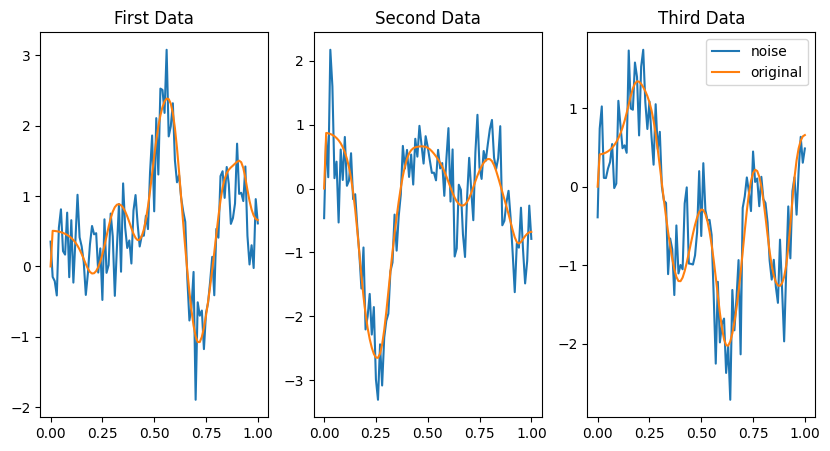

In [6]:
# visualize the first data
tseq = torch.linspace(0,1,101)

fig, ax = plt.subplots(1,3, figsize=(10,5))
ax[0].plot(tseq, noise_train[0], label="noise")
ax[0].plot(tseq, original_train[0], label="original")
ax[0].set_title("First Data")
ax[1].plot(tseq, noise_train[1], label="noise")
ax[1].plot(tseq, original_train[1], label="original")
ax[1].set_title("Second Data")
ax[2].plot(tseq, noise_train[2], label="noise")
ax[2].plot(tseq, original_train[2], label="original")
ax[2].set_title("Third Data")
plt.legend()
plt.show();

# Experiment

## Train

In [21]:
config = dict(
    epochs = 200,
    batch_size = 128,
    # lr = 3e-4,
    lr = 5e-4,
    device = "cuda" if torch.cuda.is_available() else "cpu",
    gamma = 0.5,
    step_size = 30,
    x_train_path="data/mydata/train/noise_train.pt",
    y_train_path="data/mydata/train/noise_train.pt",
    x_val_path="data/mydata/val/noise_val.pt",
    y_val_path="data/mydata/val/noise_val.pt",
    x_test_path="data/mydata/test/noise_test.pt",
    y_test_path="data/mydata/test/original_test.pt",
    model_params = dict(
        n_base = 7,
        base_hidden = [256, 256, 256, 256],
        # base_hidden = [128, 128, 128, 128],
        tseq = torch.linspace(0, 1, 101),
        dropout = 0.1,
        lambda1 = 0,
        lambda2 = 0,
        device = "cuda" if torch.cuda.is_available() else "cpu"
    )
)

In [10]:
torch.manual_seed(123)

model = MyAdaFNN(**config["model_params"]).to(config["device"])

train_pipeline(model, config)

Adjusting learning rate of group 0 to 5.0000e-04.

Epoch: [1 / 200]
------------------------------
Training loss: 2.538007 [1280/3000]
Training loss: 2.965583 [2560/3000]
Train error:
 Avg loss: 3.447783 

Validation/Test error:
 Avg loss: 6.139447 

Adjusting learning rate of group 0 to 5.0000e-04.

Epoch: [2 / 200]
------------------------------
Training loss: 1.598550 [1280/3000]
Training loss: 1.037872 [2560/3000]
Train error:
 Avg loss: 1.458901 

Validation/Test error:
 Avg loss: 4.730287 

Adjusting learning rate of group 0 to 5.0000e-04.

Epoch: [3 / 200]
------------------------------
Training loss: 1.019394 [1280/3000]
Training loss: 0.910254 [2560/3000]
Train error:
 Avg loss: 0.933052 

Validation/Test error:
 Avg loss: 5.633496 

Adjusting learning rate of group 0 to 5.0000e-04.

Epoch: [4 / 200]
------------------------------
Training loss: 0.906150 [1280/3000]
Training loss: 0.890633 [2560/3000]
Train error:
 Avg loss: 0.903428 

Validation/Test error:
 Avg loss: 4.33392

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


train_loss,█▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▆▃▄▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,0.62099
val_loss,0.70253


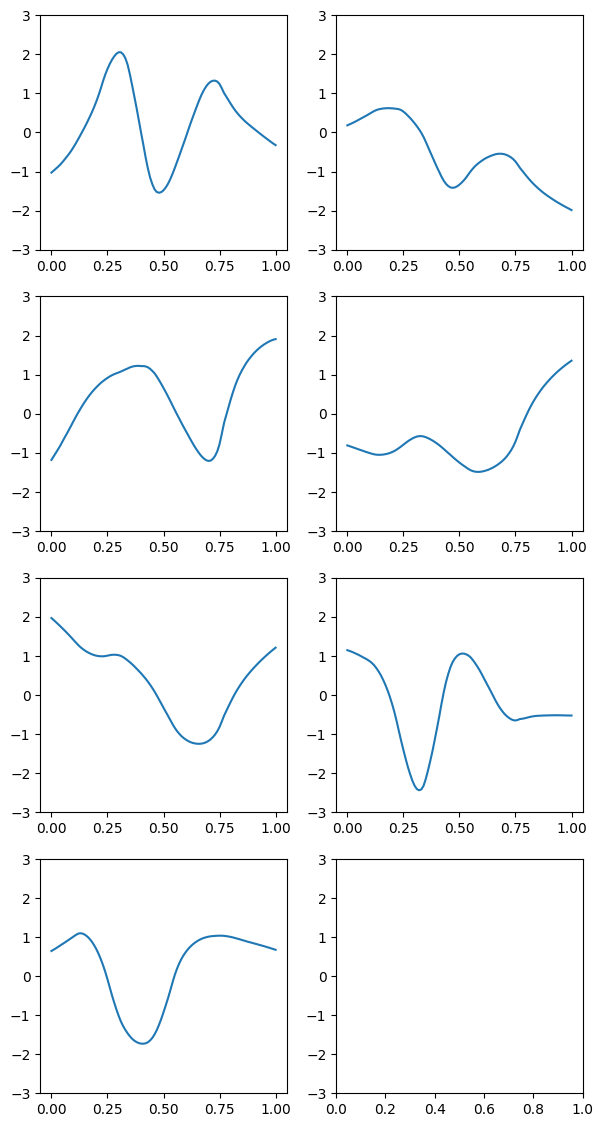

In [11]:
model.plot_bases()

In [13]:
model.check_orthonormality()

Inner Product between basis 1 and basis 2: 0.14223001897335052
Inner Product between basis 1 and basis 3: 0.09658251702785492
Inner Product between basis 1 and basis 4: -0.07828623056411743
Inner Product between basis 1 and basis 5: 0.038820043206214905
Inner Product between basis 1 and basis 6: -0.8576291799545288
Inner Product between basis 1 and basis 7: 0.11974641680717468
Inner Product between basis 2 and basis 3: -0.5244579315185547
Inner Product between basis 2 and basis 4: 0.010199833661317825
Inner Product between basis 2 and basis 5: 0.11824777722358704
Inner Product between basis 2 and basis 6: 0.10224197059869766
Inner Product between basis 2 and basis 7: -0.06424879282712936
Inner Product between basis 3 and basis 4: 0.21239852905273438
Inner Product between basis 3 and basis 5: 0.49717915058135986
Inner Product between basis 3 and basis 6: -0.483183890581131
Inner Product between basis 3 and basis 7: -0.30945533514022827
Inner Product between basis 4 and basis 5: 0.058093

## Test

In [2]:
test_pipeline(model, config)

NameError: name 'model' is not defined

In [17]:
tseq = torch.linspace(0, 1, 101)
i = 10
plt.plot(tseq, pred[i].detach(), label="pred")
plt.plot(tseq, noise_test[i], "o-", label="noise")
plt.plot(tseq, original_test[i], label="original")
plt.legend()
plt.show();

TypeError: 'int' object is not callable

## Bspline

For B-spline, we use 7 cubic basis.

In [ ]:
def check_orthonormality(self):
    for i in torch.combinations(torch.arange(self.n_base)):
        ind1, ind2 = i[0].item(), i[1].item()
        inner_prod = _inner_product(self.normalized_bases[ind1], self.normalized_bases[ind2], self.h).detach().item()
        print(f"Inner Product between basis {ind1+1} and basis {ind2+1}: {inner_prod}")

In [25]:
from skfda.representation.grid import FDataGrid
from skfda.representation.basis import BSplineBasis

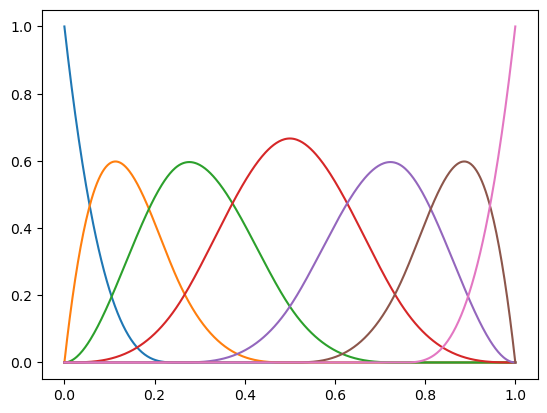

In [34]:
bsp_basis = BSplineBasis(n_basis=7)
bsp_basis.plot()
plt.show();

In [35]:
tseq = np.linspace(0,1,101)
fd = FDataGrid(data_matrix=noise_train, grid_points=tseq)
fd_b = fd.to_basis(bsp_basis)

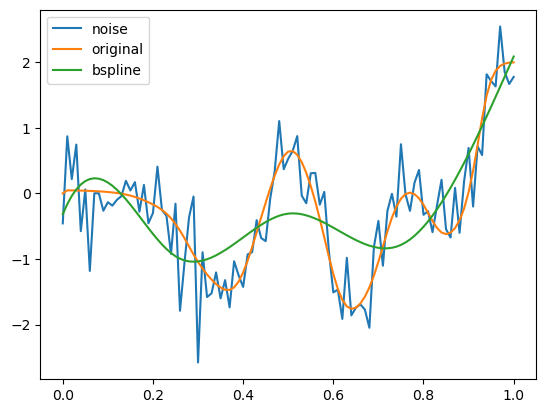

In [37]:
ind = 10
plt.plot(tseq, noise_train[ind], label="noise")
plt.plot(tseq, original_train[ind], label="original")
plt.plot(tseq, fd_b(tseq)[ind], label="bspline")
plt.legend()
plt.show();

# FPCA

In [38]:
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.grid import FDataGrid

In [40]:
tseq = np.linspace(0,1,101)
fd = FDataGrid(data_matrix=noise_train, grid_points=tseq)

fpca = FPCA(n_components=7)
fpca_scores = fpca.fit_transform(fd)

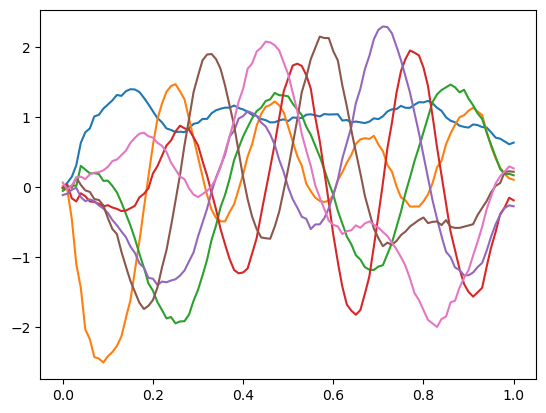

In [41]:
fpca.components_.plot();

In [42]:
fpca.singular_values_

array([21.58174712, 16.86792063, 16.14397486, 15.9523923 , 15.8317984 ,
       15.70166085, 15.4772367 ])

In [43]:
y_pred_fpca = np.matmul(fpca_scores,fpca.components_(tseq).squeeze())

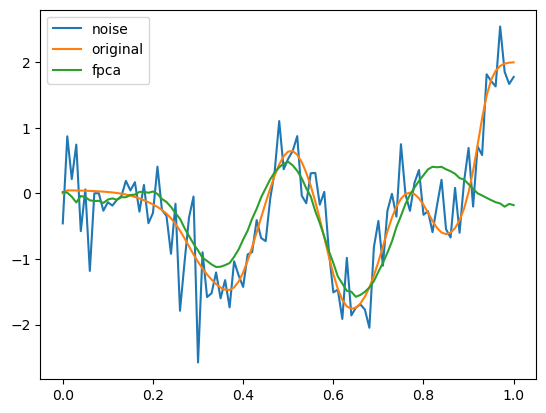

In [45]:
ind = 10
plt.plot(tseq, noise_train[ind], label="noise")
plt.plot(tseq, original_train[ind], label="original")
plt.plot(tseq, y_pred_fpca[ind], label="fpca")
plt.legend()
plt.show();

# Reference

[1] Junwen Yao, Jonas Mueller, Jane-Ling Wang. Deep Learning for Functional Data Analysis with Adaptive Basis Layers. *ICML 2021*